In [36]:
%matplotlib inline
# Load bag files
import matplotlib.pyplot as plt
import sys, rospy, rosbag, os, math
import numpy as np

splines = []

for _, _, files in os.walk("splines"):
    for file in files:
        bag = rosbag.Bag("splines/" + file)
        for topic, msg, t in bag.read_messages(topics=['stats']):
            msg.trajectoryT = list(msg.trajectoryT[:])
            was_zero = False
            for i in range(len(msg.trajectoryT)):
                if msg.trajectoryT[i] >= 3:
                    was_zero = True
                elif was_zero:
                    msg.trajectoryT[i] += 2*math.pi
                
            splines.append(msg)
        bag.close()
        print("Loaded ROS bag file from %s." % file)

Loaded ROS bag file from spline_0.bag.
Loaded ROS bag file from spline_1.bag.
Loaded ROS bag file from spline_2.bag.


The trajectories look as follows:
![Trajectories](https://dl.dropboxusercontent.com/u/17489929/Studium/Jobs/RESL/SMAP/smap_trajectories.png)

# MAE Evolution (All Voxels)

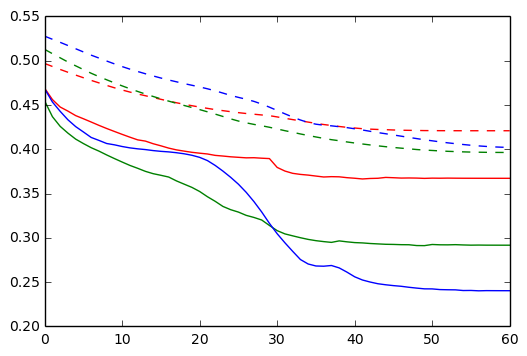

In [37]:
%matplotlib inline
colors = ["r", "g", "b"]
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    plt.plot(spline.errorEvolutionBelief, label=beliefName, c=colors[i%len(colors)])
    plt.plot(spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
#plt.legend()

# Reachability Evolution

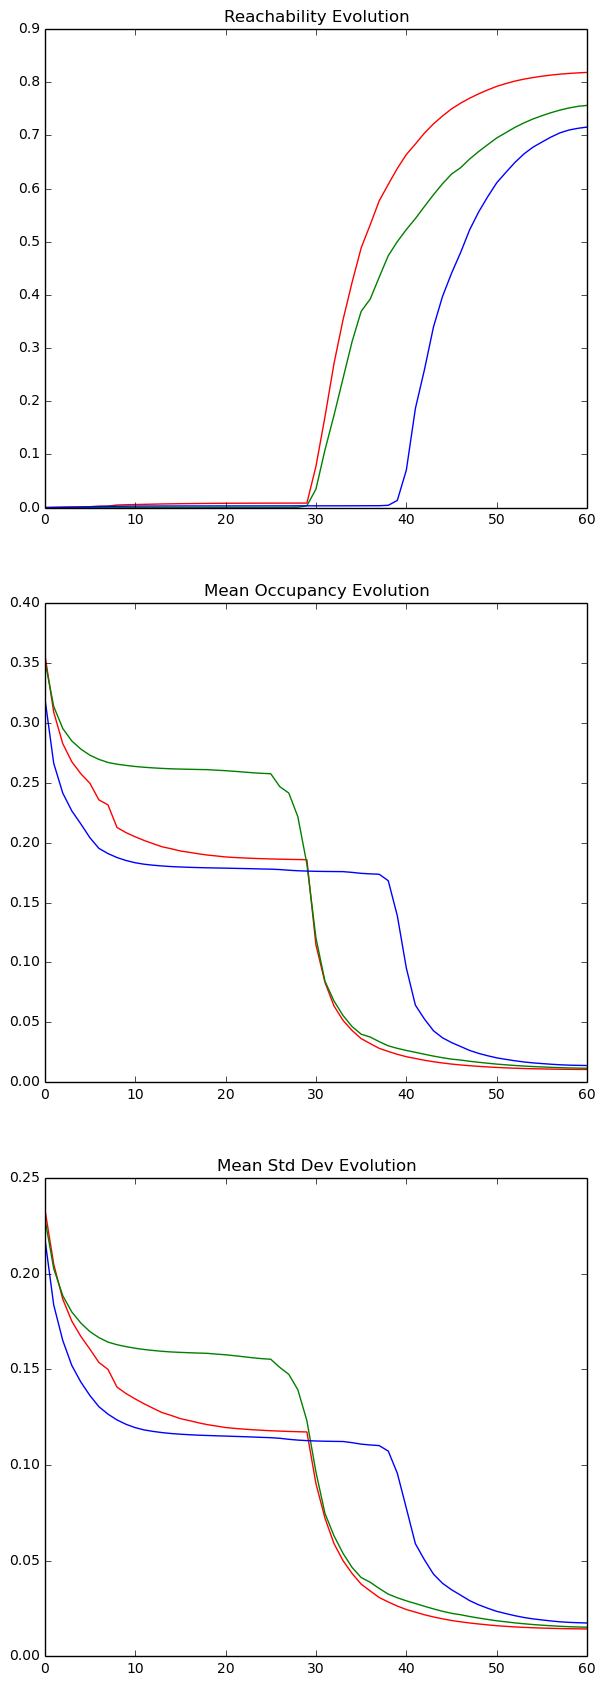

In [38]:
%matplotlib inline
plt.figure(figsize=(7,21))
sub = plt.subplot(311)
sub.set_title("Reachability Evolution")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    reachabilityBelief = np.array(spline.trajectoryOccupanciesBelief)
    reachabilityBelief = reachabilityBelief.reshape(-1, spline.trajectoryVoxels)
    ones = np.ones(reachabilityBelief.shape)
    reachabilityBelief = ones - reachabilityBelief
    reachabilityBelief = np.prod(reachabilityBelief, axis=1)
    
    
    
    sub.plot(reachabilityBelief, label=beliefName, c=colors[i%len(colors)])
    #plt.plot(spline.errorEvolutionLogOdds, label=logOddsName, linestyle='dashed', c=colors[i%len(colors)])
#plt.legend()

sub = plt.subplot(312)
sub.set_title("Mean Occupancy Evolution")
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(np.mean(mean, axis=1), label=beliefName, c=colors[i%len(colors)])
    
sub = plt.subplot(313)
sub.set_title("Mean Std Dev Evolution")
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)    
    
    sub.plot(np.mean(stddev, axis=1), label=beliefName, c=colors[i%len(colors)])

# Cost Function $\mu \cdot \sigma$

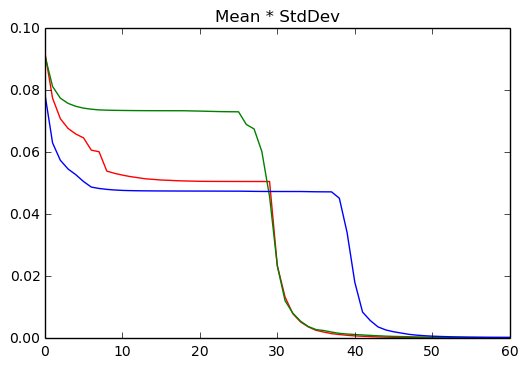

In [39]:
%matplotlib inline
plt.title("Mean * StdDev")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.multiply(mean, stddev)
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{\mu}{\sigma^2}$

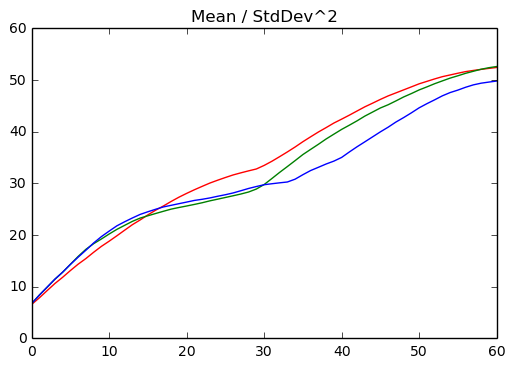

In [40]:
%matplotlib inline
plt.title("Mean / StdDev^2")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

# Cost Function $\frac{1-\mu}{\sigma^2}$

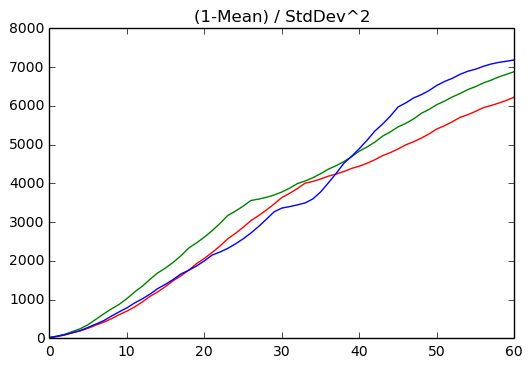

In [41]:
%matplotlib inline
plt.title("(1-Mean) / StdDev^2")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    beliefName = 'Spline #{} - SMAP'.format(i)
    logOddsName = 'Spline #{} - Log Odds'.format(i)
    mean = np.array(spline.trajectoryOccupanciesBelief)
    mean = mean.reshape(-1, spline.trajectoryVoxels)
    stddev = np.array(spline.trajectoryStdDevsBelief)
    stddev = stddev.reshape(-1, spline.trajectoryVoxels)
    cost = np.divide(1-mean, np.square(stddev))
    cost = np.mean(cost, axis=1)   
    
    
    plt.plot(cost, label=beliefName, c=colors[i%len(colors)])

In [42]:
# import requests
# import plotly.plotly as py
# from plotly.tools import FigureFactory as FF 

# data_matrix = []
# data_matrix.append([''] + list(map(lambda i: "Trajectory %i" % i, range(len(splines)))))

# reachabilities = ["Reachability"]
# cost2 = ["Cost function $\\frac{\\mu}{\\sigma^2}$"]
# cost3 = ["Cost function $\\frac{1-\\mu}{\\sigma^2}$"]
# for i, spline in enumerate(splines):
#     beliefName = 'Spline #{} - SMAP'.format(i)
#     logOddsName = 'Spline #{} - Log Odds'.format(i)
#     mean = np.array(spline.trajectoryOccupanciesBelief[-spline.trajectoryVoxels:])
#     stddev = np.array(spline.trajectoryStdDevsBelief[-spline.trajectoryVoxels:])
#     ones = np.ones(mean.shape)
#     reachabilityBelief = ones - reachabilityBelief
#     reachabilityBelief = np.prod(reachabilityBelief)
#     reachabilities.append(reachabilityBelief)
    
#     c2 = np.divide(mean, np.square(stddev))
#     c2 = np.mean(c2)
#     cost2.append(c2)
    
#     c3 = np.divide(1-mean, np.square(stddev))
#     c3 = np.mean(c3)
#     cost3.append(c3)

# data_matrix.append(reachabilities)
# data_matrix.append(cost2)
# data_matrix.append(cost3)
# table = FF.create_table(data_matrix)
# py.iplot(table, filename='simple_table')

# Time Profile

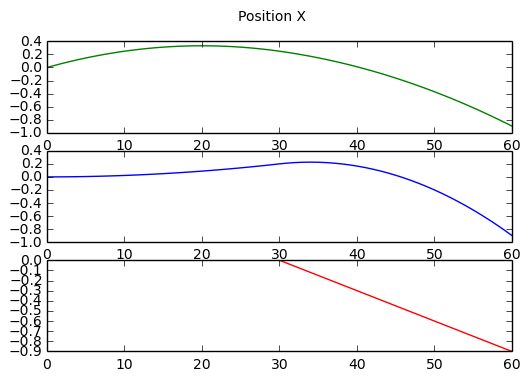

In [43]:
%matplotlib inline
plt.suptitle("Position X")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryX, c=colors[i%len(colors)])  

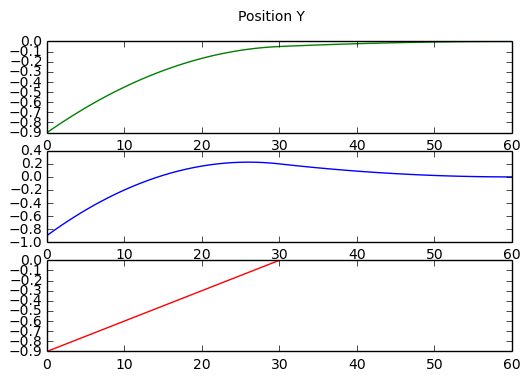

In [44]:
%matplotlib inline
plt.suptitle("Position Y")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryY, c=colors[i%len(colors)])  

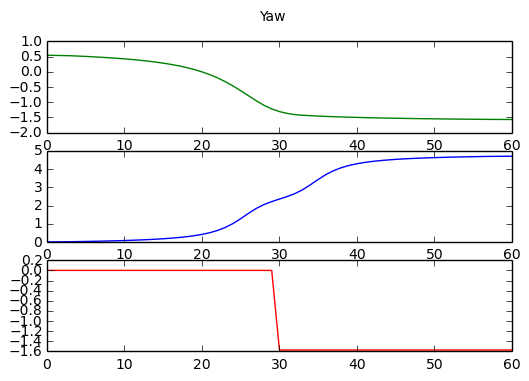

In [45]:
%matplotlib inline
plt.suptitle("Yaw")
#self.axis_fullError.set_title('Mean Absolute Error (MAE) Evolution over all Voxels')
for i, spline in enumerate(splines):
    plt.subplot(3, 1, i)
    plt.plot(spline.trajectoryT, c=colors[i%len(colors)])

In [177]:
%matplotlib inline
import math

# Linear Interpolation
def time_to_step(array, time):
    if math.ceil(time) >= len(array):
        return array[-1]
    if time <= 0:
        return array[0]
    
    frac = time - math.floor(time)
    return (1.-frac) * array[int(math.floor(time))] + frac * array[int(math.ceil(time))]


# generate planning points with equidistant arc length
TOTAL_PLANNING_POINTS = 150

def velocity_profile(spline, array, ax, min_velocity=0.01, max_velocity=0.1, acceleration=0.4, start_velocity=0, end_velocity=0):
    # planning points in x/y position
    total_arc_length = 0.
    fine_step = 0.1
    last = array[0]
    empirical_max_velocity = 0
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        total_arc_length += math.sqrt(((x-last)*1.) ** 2 + (fine_step) ** 2)
        empirical_max_velocity = max(empirical_max_velocity, abs(x-last))
        last = x
    print "Total arc length:", total_arc_length
        
    first_derivative = [0]
    last = array[0]
    max_first_derivative = 0.
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        first_derivative.append(abs(x-last)/fine_step)
        max_first_derivative = max(max_first_derivative, first_derivative[-1])
        last = x
        
    #ax.plot(first_derivative)
        
    second_derivative = [0]
    last = first_derivative[0]
    max_second_derivative = 0.
    for s in np.arange(fine_step, len(array), fine_step):
        x = first_derivative[int(s/fine_step)]
        second_derivative.append(abs(x-last)/fine_step)
        max_second_derivative = max(max_second_derivative, second_derivative[-1])
        last = x
    #print second_derivative[:20]
    
    #ax.plot(second_derivative)
    
    curvature = []
    for first, second in zip(first_derivative, second_derivative):
        curvature.append(abs(second)/(1.+first**2)**(3./2.))
#     plt.plot(first_derivative)
#     plt.plot(second_derivative)
    #print curvature
    #ax.plot(curvature)

    # arc length between equidistant planning points
    delta_s = total_arc_length / TOTAL_PLANNING_POINTS

    # compute equidistant planning points
    planning_points = []
    arc_length = 0.
    current_arc = 0.
    last = array[0]
    planning_points.append([array[0], current_arc, start_velocity])
    i = 9
    for s in np.arange(fine_step, len(array), fine_step):
        x = time_to_step(array, s)
        d = math.sqrt(((x-last)*1.) ** 2 + (fine_step) ** 2)
        arc_length += d
        current_arc += d
        if arc_length >= delta_s:
            # scale velocity such that empirical max velocity is desired max
            max_rot_vel = 5e-9
            
            velocity = min(max_velocity, max_rot_vel/curvature[int(i)]) if curvature[int(i)] > 0 else max_velocity
            velocity = max(velocity, min_velocity)
            if curvature[int(i)] > 10:
                velocity = 0
#                 print i, ": ", curvature[int(i)]
            #velocity = first_derivative[int(i)]
#             if curvature[int(i)] > 0:
#                 print curvature[int(i)]
            
            planning_points.append([x, current_arc, velocity])
            arc_length = 0.
        
#         if curvature[int(i)] > 10:
#             velocity = 0
            #print i, ": ", curvature[int(i)]
        i += 1
        if i >= len(curvature):
            break
        last = x
    #print "last i:", i
    
    planning_points.append([array[-1], current_arc, end_velocity])

    arcs = list(map(lambda p: p[1], planning_points))
    velocities = list(map(lambda p: p[2], planning_points))
    ax.scatter(arcs, velocities, label="initial", c="black")

    # update velocities (forward pass)
    v = start_velocity
    for i, (p, nextp) in enumerate(zip(planning_points, planning_points[1:])):
        p[2] = min(p[2], v)
        planning_points[i][2] = p[2]
        vs = []
        ss = []
        if nextp[1] == p[1]:
            continue
        for s in np.arange(0, nextp[1]-p[1], (nextp[1]-p[1])/20.):
            v = p[2] + acceleration * s
            vs.append(v)
            ss.append(p[1] + s)
        ax.plot(ss, vs, c="r")

    # update velocities (backward pass)
    v = end_velocity
    for i in range(1, len(planning_points)):
        p = planning_points[-i]
        nextp = planning_points[-i-1]
        p[2] = min(p[2], v)
        planning_points[-i][2] = p[2]
        vs = []
        ss = []
        if nextp[1] == p[1]:
            continue
        for s in np.arange(0, nextp[1]-p[1], (nextp[1]-p[1])/20.):
            v = p[2] - acceleration * s
            vs.append(v)
            ss.append(p[1] + s)
        ax.plot(ss, vs, c="b")


    arcs = list(map(lambda p: p[1], planning_points))
    velocities = list(map(lambda p: p[2], planning_points))
    ax.scatter(arcs, velocities, label="initial", c="y")
    ax.plot(arcs, velocities, c="black", linestyle="dashed")
    ax.set_xlabel("Arc Length")
    ax.set_ylabel("Velocity")
    return planning_points

def plot_spline(spline_id):
    f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', figsize=(10,8))
    f.suptitle("Spline %i" % spline_id)
    print "Spline", spline_id
    print "Position X"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryX, ax1, acceleration=0.02)
    print "Position Y"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryY, ax3, acceleration=0.02)
    print "Position Z"
    velocity_profile(splines[spline_id], splines[spline_id].trajectoryT, ax5, acceleration=0.02)
    ax2.plot(splines[spline_id].trajectoryX, c=colors[spline_id%len(colors)])
    ax2.set_ylabel("Position X")
    ax4.plot(splines[spline_id].trajectoryY, c=colors[spline_id%len(colors)])
    ax4.set_ylabel("Position Y")
    ax6.plot(splines[spline_id].trajectoryT, c=colors[spline_id%len(colors)])
    ax6.set_ylabel("Yaw Angle")

Spline 0
Position X
Total arc length: 60.9134969632
Position Y
Total arc length: 60.9134969632
Position Z
Total arc length: 61.7620958891


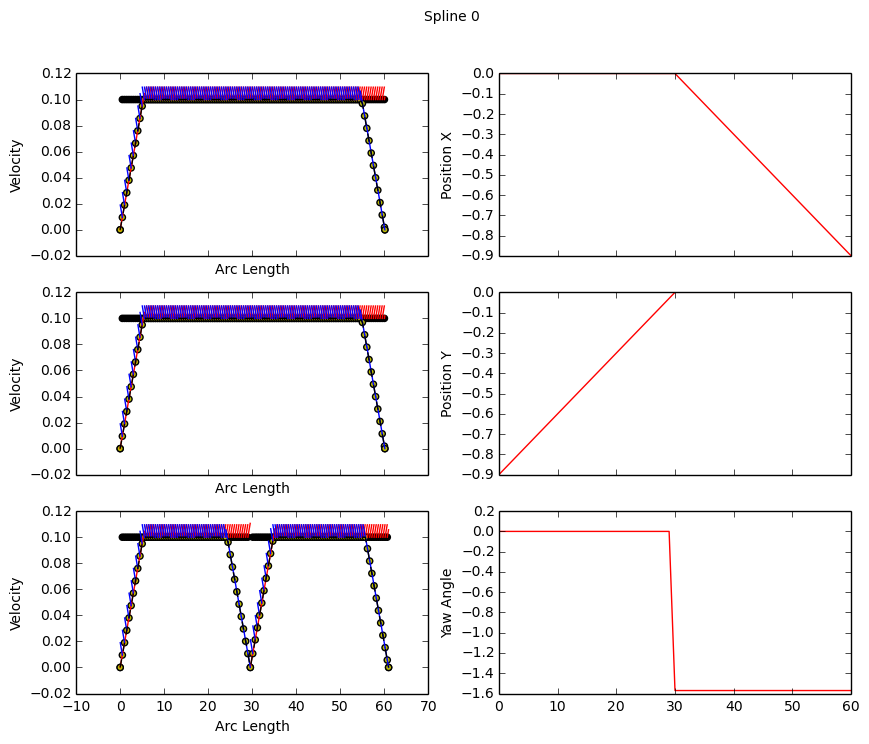

In [167]:
plot_spline(0)

In [214]:
import csv
def time_profile(spline_id):
    f = open("timing_%i.csv" % spline_id, "w")
    array = splines[spline_id].trajectoryT
    planning_points = velocity_profile(splines[spline_id], array, ax1, acceleration=0.008, max_velocity=5.)
    total_arc_length = 0.
    velocities = list(map(lambda p: p[2], planning_points))

    total_time = 0.
    relative_total_time = 0
    for p, lastp in zip(planning_points[1:], planning_points):
        for s in np.arange(0, 1, 1):
            delta_s = (p[1] - lastp[1]) * 1
            #delta_t = 2 * delta_s / (p[2] + lastp[2])
            delta_t = (2 * delta_s / (p[2] + lastp[2]))
            total_time += delta_t
            relative_total_time += p[2] * s + lastp[2] * (1-s)

    print "Total time:", total_time
    times = []
    trajectory = []
    time = 0.

    def arc_to_step(array, arc):
        arc_length = 0.
        last = array[0]
        for s in np.arange(0.01, len(array), 0.01):
            x = time_to_step(array, s)
            d = math.sqrt(((x-last)*10.) ** 2 + (0.01) ** 2)
            arc_length += d
            if arc_length >= arc:
                return x
            last = x

    arc = 0
    total_arc = planning_points[-1][1]
    for p, lastp in zip(planning_points[1:], planning_points):
        for s in np.arange(0, 1, 1):
            delta_s = (p[1] - lastp[1]) * 1
            arc += delta_s
            #delta_t = 2 * delta_s / (p[2] + lastp[2])
            delta_t = (p[2] * s + lastp[2] * (1-s))
            time += delta_t
            t = time/relative_total_time * total_time
            times.append(t)
            f.write("%f\n" % t)
            #trajectory.append(arc_to_step(array, arc))
            trajectory.append(time_to_step(array, arc/total_arc * len(array)))
            #trajectory.append(time_to_step(array, time/total_time * len(array)))
            #trajectory.append(time_to_step(array, time/total_time * total_arc))
       
    f.close()
    ax = plt.subplot(111)
    ax.scatter(times, trajectory, s=0.1)
    ax.scatter(times, [-2]*len(times), s=0.1, edgecolor="b")
    ax.set_xlabel("Time")
    ax.set_ylabel("Yaw")
    return times

Total arc length: 61.7620958891
Total time: 2864.2775587


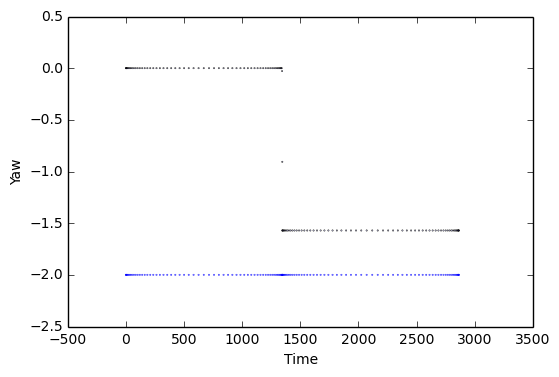

In [215]:
_ = time_profile(0)

Spline 1
Position X
Total arc length: 60.9285354268
Position Y
Total arc length: 60.9152122729
Position Z
Total arc length: 61.0037117833


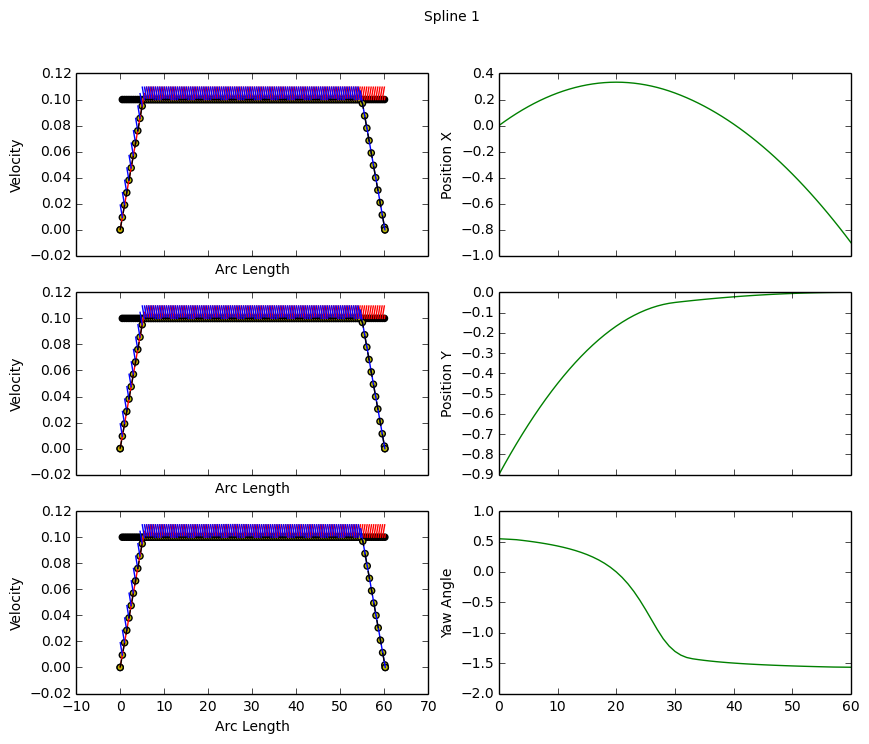

In [216]:
plot_spline(1)

Total arc length: 61.0037117833
Total time: 1760.39647981


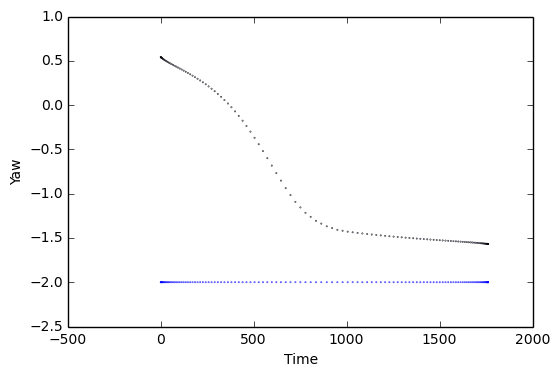

In [217]:
_ = time_profile(1)

Spline 2
Position X
Total arc length: 60.9335048654
Position Y
Total arc length: 60.9335048652
Position Z
Total arc length: 61.3268651941


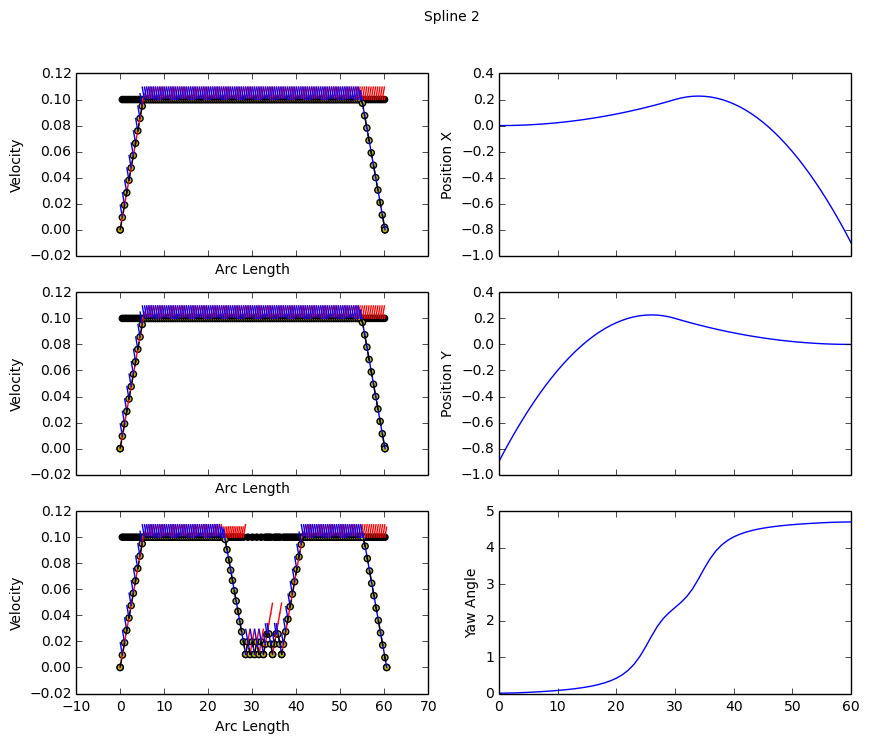

In [218]:
plot_spline(2)

Total arc length: 61.3268651941
Total time: 2675.84408691


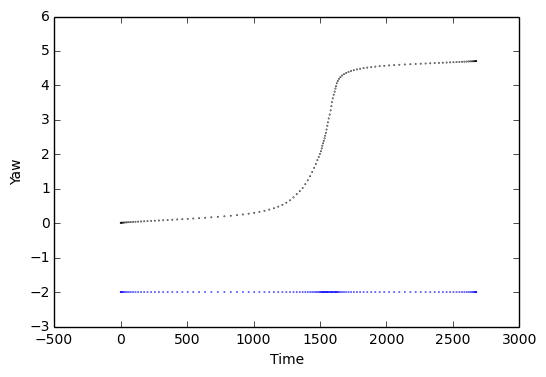

In [219]:
_ = time_profile(2)